In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_squared_log_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVC
from sklearn.ensemble import StackingRegressor
import warnings
warnings.filterwarnings("ignore")
import smogn

In [31]:
# import data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

Total number of duplicate columns :  34


(array([  0.5,  10.5,  20.5,  30.5,  40.5,  50.5,  60.5,  70.5,  80.5,
         90.5, 100.5, 110.5, 120.5, 130.5, 140.5, 150.5, 160.5, 170.5,
        180.5, 190.5, 200.5, 210.5, 220.5, 230.5, 240.5, 250.5, 260.5,
        270.5, 280.5, 290.5, 300.5, 310.5, 320.5, 330.5, 340.5, 350.5,
        360.5, 370.5, 380.5]),
 <a list of 39 Text xticklabel objects>)

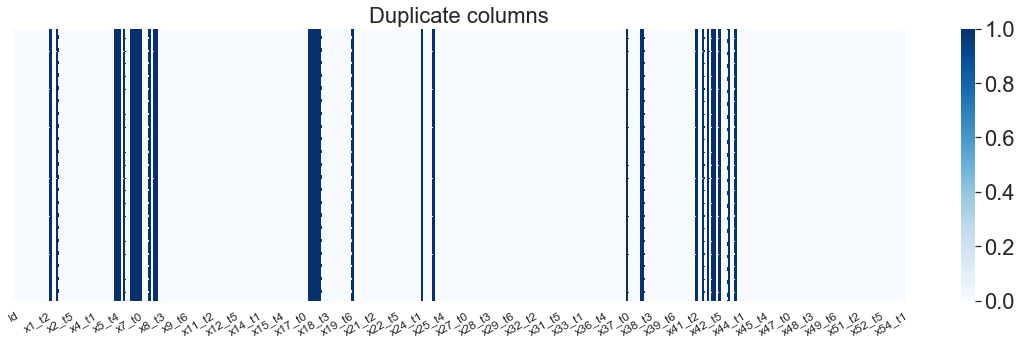

In [32]:
# Find Duplicate columns

train3 = train.copy()
a = train3.columns.tolist()

# Drop duplicate columns
train2 = train3.T.drop_duplicates(keep='first').T
b=train2.columns

print('Total number of duplicate columns : ', (len(a)-len(b)))

# save duplicate columns name
dupp = []
for i in range(len(a)):
    if a[i] not in b:
        dupp.append(a[i])
        
for i in range(len(dupp)):
    train3[dupp[i]] = np.nan

# plot missing values
fig, ax = plt.subplots(figsize=(20,5))
sns.set(font_scale=2)
plt.title('Duplicate columns', fontsize=22)
sns.heatmap(train3.isnull(), cmap="Blues", yticklabels=False, ax=ax)
plt.xticks(fontsize = 12, rotation = 30)

In [33]:
# 0 variance columns
num_zero_var = 0
for i in range(387):
    a = train4[train4.columns[i]].var()
    if a == 0:
        num_zero_var += 1
    
print('Total {} coumns have 0 variance'.format(num_zero_var))

Total 13 coumns have 0 variance


Text(0.5, 1.0, 'Top 15 correlated features with target')

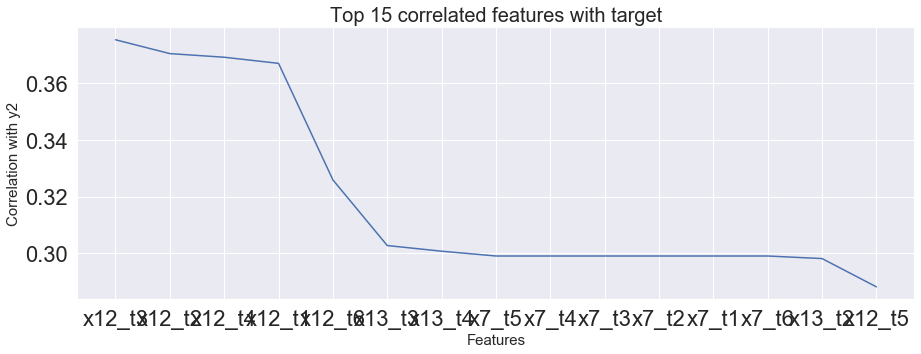

In [34]:
# most correlated features
corr_df = pd.DataFrame({'cols':train.columns[1:-1]})
corr_df['val'] = 0

for i in range(len(train.columns[1:-1])):
    corr_df.iloc[i,1] = (train['y2'].corr(train[train.columns[i]]))
    
corr_df.val = corr_df.val.apply(lambda x : np.abs(x))
corr_df = corr_df.sort_values(by = ['val'],ascending=False).dropna()

plt.figure(figsize = (15,5))
plt.plot(corr_df.cols[:15],corr_df.val[:15])
plt.xlabel('Features', fontsize = 15)
plt.ylabel('Correlation with y2', fontsize = 15)
plt.title('Top 15 correlated features with target', fontsize = 20)

In [35]:
# Find columns average
cols = []
for i in range(1,train.shape[1]-5,7):
    train[train.columns[i]] = (train[train.columns[i]]+train[train.columns[i+1]]+train[train.columns[i+2]]+train[train.columns[i+3]]+train[train.columns[i+4]]+train[train.columns[i+5]]+train[train.columns[i+6]])/7
    cols.append(train.columns[i])

cols.append('Id')
cols.append('y2')


In [36]:
# Drop rest of the columns
train.drop([c for c in train.columns if c not in cols], axis = 1, inplace = True)
train4 = train.copy()

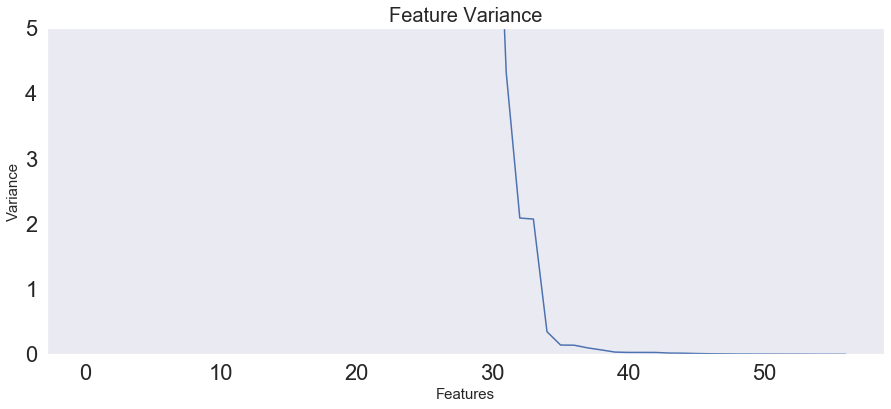

In [37]:
# plot variance
plt.figure(figsize=(15,6))
plt.plot(range(57),train.var().sort_values(ascending=False))
plt.ylim(0,5)
plt.xlabel('Features', fontsize = 15)
plt.ylabel('Variance', fontsize = 15)
plt.title('Feature Variance', fontsize = 20)
plt.grid()

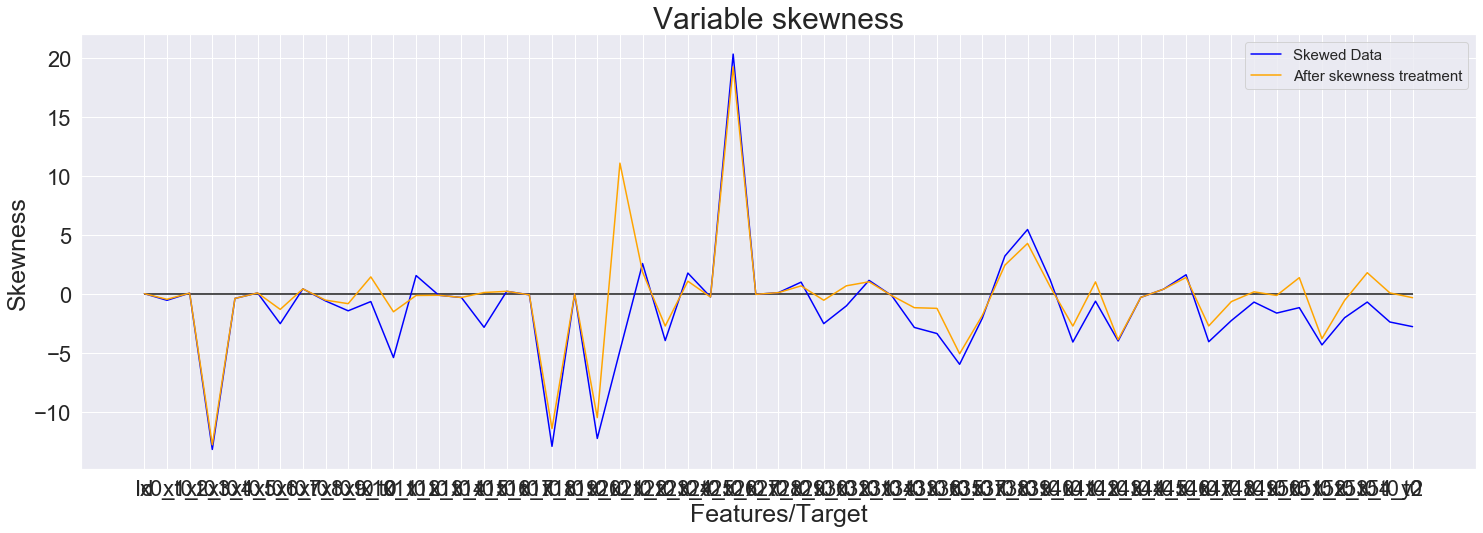

In [39]:
# skewness treat
plt.figure(figsize = (25,8))
plt.plot(train4.skew(), color = 'blue', label = 'Skewed Data')

memo = []
for i in range(len(train4.skew())):
    if train4.skew()[i] > 0.5:
        train4[train4.skew().index[i]] = train4[train4.skew().index[i]].apply(lambda x : np.log1p(x))
        memo.append(1)
    elif train4.skew()[i] < -0.5:
        train4[train4.skew().index[i]] = train4[train4.skew().index[i]].apply(lambda x :x*x*x)
        memo.append(-1)
    else:
        memo.append(0)
        
plt.plot(train4.skew(), color = 'orange', label = 'After skewness treatment')
plt.hlines(0,0,56)
plt.legend(prop={'size': 15})
plt.xlabel('Features/Target', fontsize = 25)
plt.ylabel('Skewness', fontsize = 25)
plt.title('Variable skewness', fontsize = 30)
plt.show()

In [282]:
# split predictors and target
X = train.drop('y2',axis = 1)
y = train['y2'].copy()

# Standardize independent variables
ss = StandardScaler()
X = ss.fit_transform(X)

Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.


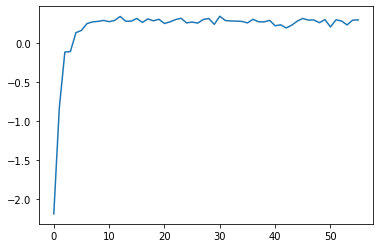

In [283]:
# rfecv
rfe_estimator = RandomForestRegressor()
rfecv_1 = RFECV(rfe_estimator, step=1, min_features_to_select=1, scoring='r2', verbose=12, n_jobs=-1)
rfecv_1.fit(X,y)
X_rfe = rfecv_1.transform(X)
plt.plot(rfecv_1.grid_scores_[:])

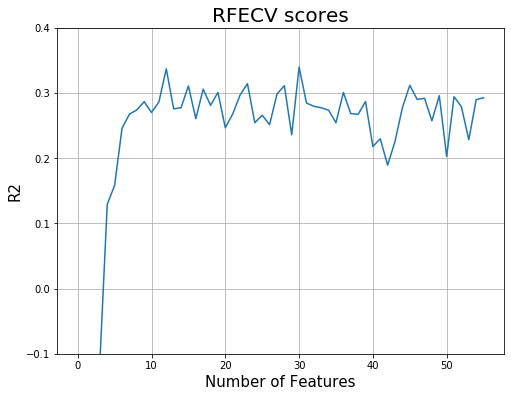

In [284]:
# plot r2 score vs number of features selected by rfecv
plt.figure(figsize=(8,6))
plt.plot(rfecv_1.grid_scores_[:])
plt.xlabel('Number of Features', fontsize = 15)
plt.ylabel('R2', fontsize = 15)
plt.title('RFECV scores', fontsize = 20)
plt.ylim(-0.1,0.4)
plt.grid()
plt.show()

In [285]:
# Linear Regression
lr = LinearRegression()
l1 = Lasso()
l2 = Ridge()
svr = SVR(kernel='linear')
rf = RandomForestRegressor(n_jobs = -1)
xgb = XGBRegressor()

lr_cv = cross_val_score(lr, X_rfe,y, scoring = 'r2', cv = 5, n_jobs = -1).mean()
print(lr_cv)
l1_cv = cross_val_score(l1, X_rfe,y, scoring = 'r2', cv = 5, n_jobs = -1).mean()
print(l1_cv)
l2_cv = cross_val_score(l2, X_rfe,y, scoring = 'r2', cv = 5, n_jobs = -1).mean()
print(l2_cv)
svr_cv = cross_val_score(svr, X_rfe,y, scoring = 'r2', cv = 5, n_jobs = -1).mean()
print(svr_cv)
rf_cv = cross_val_score(rf, X_rfe,y, scoring = 'r2', cv = 8, n_jobs = -1).mean()
print(rf_cv)
xgb_cv = cross_val_score(xgb, X_rfe,y, scoring = 'r2', cv = 8, n_jobs = -1).mean()
print(xgb_cv)

-0.05733308740278422
-0.003529473527464777
-0.05455645477514561
0.13862013386025523
0.3260194710157113
-1.0540247493320907


In [272]:
# Model Stacking 
estimators = [
     ('lr', LinearRegression()),('l1', Lasso()),('l2', Ridge()),
     ('svr', SVR(kernel='linear')),('rf', RandomForestRegressor(n_jobs = -1)),('xgb', XGBRegressor())
]
sreg = StackingRegressor(estimators=estimators,
                         final_estimator=Ridge())
stk_cv = cross_val_score(sreg, X_rfe,y, scoring = 'r2', cv = 5, n_jobs = -1).mean()
print(stk_cv)

0.38676698293137607


In [306]:
# Over-sampling
train_smogn = smogn.smoter(data = train,y = "y2")

r_index: 100%|########################################################################| 82/82 [00:00<00:00, 122.61it/s]


In [307]:
print('Shape of training data after over-sampling ',train_smogn.shape, ' whereas original train data shape = ', train.shape)

Shape of training data after over-sampling  (856, 57)  whereas original train data shape =  (794, 57)


In [308]:
# split over sampled data
Xs = train_smogn.drop('y2',axis = 1)
ys = train_smogn['y2'].copy()

# Standardize
sss = StandardScaler()
Xs = sss.fit_transform(Xs)

Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 fe

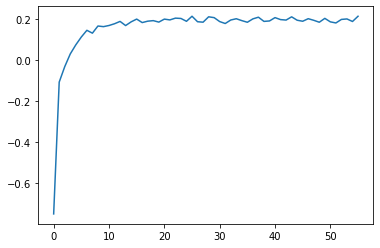

In [309]:
# RFECV for over-sampled data
rfe_estimators = RandomForestRegressor()
rfecv_1s = RFECV(rfe_estimators, step=1, min_features_to_select=1, scoring='r2', verbose=12, n_jobs=-1)
rfecv_1s.fit(Xs,ys)
X_rfes = rfecv_1s.transform(Xs)
plt.plot(rfecv_1s.grid_scores_[:])

In [315]:
# Cross validating Vanilla models
lr = LinearRegression()
l1 = Lasso()
l2 = Ridge()
svr = SVR(kernel='linear')
rf = RandomForestRegressor(n_jobs = -1)
xgb = XGBRegressor()

lrs_cv = cross_val_score(lr, X_rfes,ys, scoring = 'r2', cv = 5, n_jobs = -1).mean()
print(lrs_cv)
l1s_cv = cross_val_score(l1, X_rfes,ys, scoring = 'r2', cv = 5, n_jobs = -1).mean()
print(l1s_cv)
l2s_cv = cross_val_score(l2, X_rfes,ys, scoring = 'r2', cv = 5, n_jobs = -1).mean()
print(l2s_cv)
svrs_cv = cross_val_score(svr, X_rfes,ys, scoring = 'r2', cv = 5, n_jobs = -1).mean()
print(svrs_cv)
rfs_cv = cross_val_score(rf, X_rfes,ys, scoring = 'r2', cv = 8, n_jobs = -1).mean()
print(rfs_cv)
xgbs_cv = cross_val_score(xgb, X_rfes,ys, scoring = 'r2', cv = 8, n_jobs = -1).mean()
print(xgbs_cv)

-0.23834303489446645
-1.1738707416939487
-0.23860836035254995
-0.21826536407922742
0.29710089016518787
0.2547057471385854


'-0.8039721344501704\n-1.1738707416939487\n-0.6005382250844837\n-0.8291626951165328\n0.2929811403681152\n0.2435881583956529'

In [351]:
# xgb hyper-parameter tuning
grid = {
    'max_depth' : [6],'min_child_weight' : [1],
    'n_estimators' : [1000],
    'gamma' : [0],
    'subsample':[0.95],'colsample_bytree':[0.85],
    'reg_alpha':[0.1],
    'learning_rate' : [0.15]
}
gs1 = GridSearchCV(XGBRegressor(), grid, n_jobs=-1, verbose=2,scoring='r2',return_train_score=True)
gs1.fit(X_rfes,ys)

Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   47.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 175 out of 175 | elapsed:  2.6min finished


GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,...
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=None,
                                    verbosity=None),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.85], 'gamma': [0],
       

In [352]:
# print best tuning scores & parameters
print('After Hyper-parameter Tuning')
print(gs1.best_params_)
print(gs1.best_score_)

{'colsample_bytree': 0.85, 'gamma': 0, 'learning_rate': 0.15, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 1000, 'reg_alpha': 0.1, 'subsample': 0.95}
0.3080227167557553
0.9933389868999699


In [354]:
# best model
xgb_ht = XGBRegressor(max_depth = 6, colsample_bytree = 0.85, gamma = 0, learning_rate = 0.15,
                      min_child_weight = 1, n_estimators = 1000, reg_alpha = 0.1, subsample = 0.95)
print('Hyper-parameter tuned XGBRegressor : ')
xgb_ht.fit(X_rfes,ys)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.85, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.15, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0.1, reg_lambda=1, scale_pos_weight=1, subsample=0.95,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [463]:
# stacking regressor - stacking Linear Regression, RandomForest & XGBoost
estimators = [
     ('lr', LinearRegression()),('l1', Lasso()),('l2', Ridge()),
     ('svr', SVR(kernel='linear')),('rf', RandomForestRegressor(n_jobs = -1)),('xgb', xgb_ht)
]
sreg = StackingRegressor(estimators=estimators,
                         final_estimator=Ridge())
stk_cv = cross_val_score(sreg, X_rfes,ys, scoring = 'r2', cv = 5, n_jobs = -1).mean()
print('Mean Cross Validation score for StackingRegressor : ',stk_cv)

[-0.58405894  0.43541261  0.47832516  0.47743081  0.39254113]


In [318]:
# test data
# prepare the test data
id_ = test['Id']
cols2 = []
for i in range(1,test.shape[1]-5,7):
    test[test.columns[i]] = (test[test.columns[i]]+test[test.columns[i+1]]+test[test.columns[i+2]]+test[test.columns[i+3]]+
                             test[test.columns[i+4]]+test[test.columns[i+5]]+test[test.columns[i+6]])/7
    cols2.append(test.columns[i])

cols2.append('Id')

test.drop([c for c in test.columns if c not in cols2], axis = 1, inplace = True)
        
test = sss.transform(test)
test = rfecv_1s.transform(test)

In [403]:
# predict and export data
pred_ = model_test.predict(test)
sub = pd.DataFrame({'Id':id_,'y2':pred_})
#sub.to_csv('sub.csv',index = False)

In [464]:
# Further evaluation of model
xtrain,xtest,ytrain,ytest = train_test_split(X_rfes,ys,test_size = 0.2, shuffle = True,random_state = 193)
model_test = XGBRegressor()
pred = sreg.fit(xtrain,ytrain).predict(xtest)

0.7866795713044002


In [465]:
# model performance
# MAE
mae = round(mean_absolute_error(ytest, pred),4)

# RMSE
rmse = round(np.sqrt(mean_squared_error(ytest, pred)),4)

# RMSLE
rmsle = round(np.sqrt(np.mean((np.log1p(pred) - np.log1p(ytest))**2)),4)

# R-Squared
r2 = round(r2_score(ytest, pred),4)

print('       Mean Absolute Error : ',mae)
print('    Root Mean Square Error : ',rmse)
print('Root Mean Square Log Error :',rmsle)
print('                        r2 :',r2)

0.0857 0.1118 0.076 0.7867


Text(0.5, 1.0, 'Model performance')

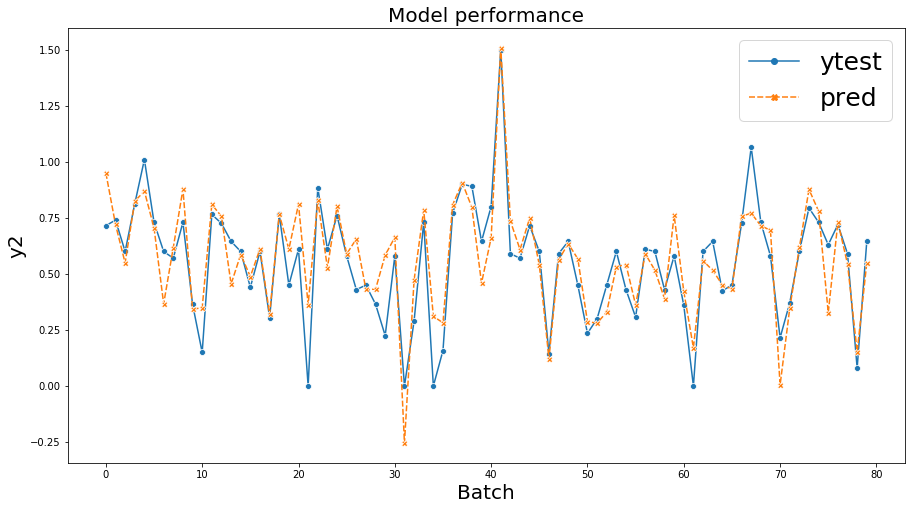

In [460]:
# Model prediction vs Actual performance
plt_df = pd.DataFrame({'ytest':ytest,'pred':pred})

plt.figure(figsize=(15,8))
sns.lineplot(data=plt_df.reset_index().drop('index',axis=1).iloc[:80,:],style="event",markers=True)
plt.xlabel('Batch', fontsize = 20)
plt.ylabel('y2', fontsize = 20)
plt.legend(prop={'size': 25})
plt.title('Model performance', fontsize=20)